<h1 style='text-align: center;'>Credit Card Fraud Detection</h1>

Dataset obtenido de Kaggle ([link](https://www.kaggle.com/mlg-ulb/creditcardfraud/))

## Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature <span style='color:orange;font-weight:bold'>'Time'</span> contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- Feature <span style='color:orange;font-weight:bold'>'Amount'</span> is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
- Feature <span style='color:orange;font-weight:bold'>'Class'</span> is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [40]:
from pathlib import Path
import warnings
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
p = Path('.')
df = pd.read_csv(p / 'creditcard.csv')

In [181]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

Separo entre features predictoras y target para empezar el análisis exploratorio

In [3]:
X = df.copy()
y = X.pop('Class')

In [6]:
X.shape

(284807, 30)

In [7]:
X.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64

Las features predictoras no tienen valores nulos, así que no será necesario imputar.

In [128]:
X.dtypes.value_counts()

float64    30
dtype: int64

Como se indica en la descripción, todas las variables son numéricas.

In [8]:
X.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V20           V21           V22           V23  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  6.406703e-16  1.656562e-16 -3.444850e-16  2.578648e-16   
std    ...  7.709250e-01  7.345240e-01  7.257016e-01  6.244603e-01   
min    ... -5.449772e+01 -3.483038e+01 -1.093314e+01 -4.480774e+01   
25%    ... -2.117214e-01 -2.283949e-01 -5.423504e-01 -1.618463e-01   
50%    ... -6.248109e-02 -2.945017e-02  6.781943e-03 -1.119293e-02   
75%    ...  1.330408e-01  1.863772e-01  5.285536e-01  1.476421e-01   
max    ...  3.942090e+01  2.720284e+01  1.050309e+01  2.252841e+01   

                V24           V25           V26           V27           V28  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   4.471968e-15  5.340915e-16  1.687098e-15 -3.666453e-16 -1.220404e-16   
std    6.056471e-01  5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01   
min   -2.836627e+00 -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01   
25%   -3.545861e-01 -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02   
50%    4.097606e-02  1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02   
75%    4.395266e-01  3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02   
max    4.584549e+00  7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   

              Amount  
count  284807.000000  
mean       88.349619  
std       250.120109  
min         0.000000  
25%         5.600000  
50%        22.000000  
75%        77.165000  
max     25691.160000  

[8 rows x 30 columns]

Todas las variables están estandarizadas salvo por ```Time``` y ```Amount```, lo cual se sigue del hecho de que las variables V1-V28 sean los componentes principales del dataset original.

Veamos qué tan balanceado está el target

In [3]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

# Feature selection

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [11]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_classif at 0x00000145AA2C9E18>)

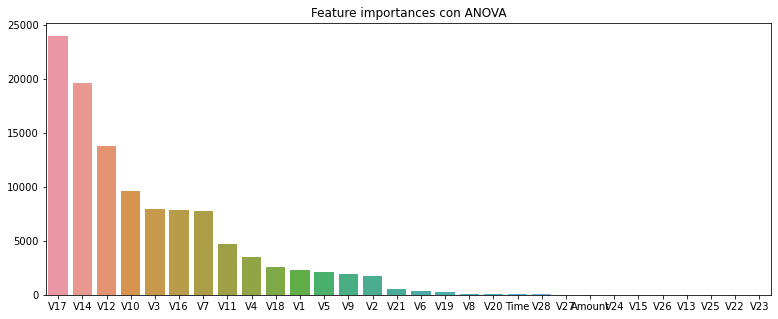

In [28]:
scores = pd.Series(fs.scores_, index=X_train.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(x=scores.index, y=scores.values)
plt.title('Feature importances con ANOVA')
plt.show()

Intenté correr mutual information para variables categóricas pero tardó muchísimo. Por lo pronto me quedaré con los resultados de ANOVA.

In [34]:
most_relevant = scores[:10]

# Modelado

## Regresión logística

In [7]:
logit = LogisticRegression(random_state=0)
logit.fit(X_train, y_train)
preds_logit = logit.predict(X_test)

In [15]:
report = classification_report(y_test, preds_logit)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.52      0.66       147

    accuracy                           1.00     85443
   macro avg       0.94      0.76      0.83     85443
weighted avg       1.00      1.00      1.00     85443



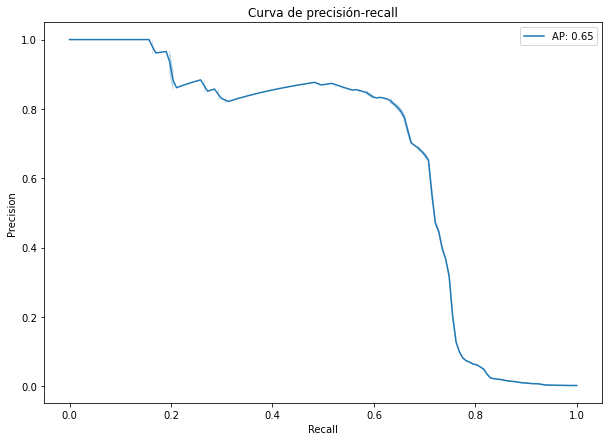

In [22]:
# calculate probabilities predicted by logit
# then calculate precision recall curve and average precision
preds_proba = logit.predict_proba(X_test)
positive_preds_proba = preds_proba[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, positive_preds_proba)
average_precision = average_precision_score(y_test, positive_preds_proba)

fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(recall, precision, label=f'AP: {round(average_precision,2)}')
plt.title('Curva de precisión-recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

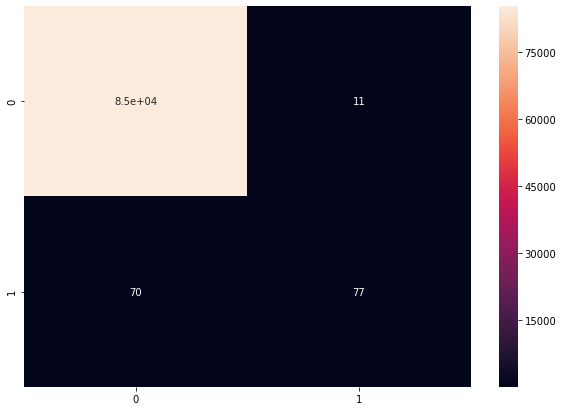

In [9]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, preds_logit), annot=True)
plt.show()

### Conclusión de regresión logística

El modelo es muy malo para detectar transacciones fraudulentas.

---

## Random Forest

In [118]:
params = {
    'n_estimators': 1000,
    'max_depth': 3,
    'min_samples_leaf': 2
}
random_forest = RandomForestClassifier(random_state=0, **params)
# random_forest.fit(X_train, y_train)


# with open('random_forest_classif.pkl', 'wb') as random_forest_pkl:
#     pickle.dump(random_forest, random_forest_pkl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Este modelo tarda bastante en entrenar, por lo que lo almaceno en un pickle para levantarlo rápidamente la próxima vez

In [23]:
with open('random_forest_classif.pkl', 'rb') as random_forest_pkl:
    random_forest = pickle.load(random_forest_pkl)

In [24]:
random_forest_preds = random_forest.predict(X_test)

In [25]:
report_random_forest = classification_report(y_test, random_forest_preds)
print(report_random_forest)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.87      0.59      0.70       147

    accuracy                           1.00     85443
   macro avg       0.93      0.79      0.85     85443
weighted avg       1.00      1.00      1.00     85443



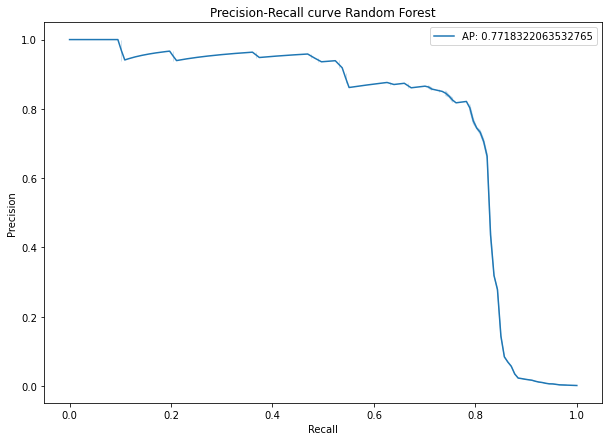

In [39]:
random_forest_pred_probas = random_forest.predict_proba(X_test)
random_forest_preds_pos_proba = random_forest_pred_probas[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, random_forest_preds_pos_proba)
average_precision = average_precision_score(y_test, random_forest_preds_pos_proba)

fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(recall, precision, label=f'AP: {round(average_precision, 2)}')
plt.title('Precision-Recall curve Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

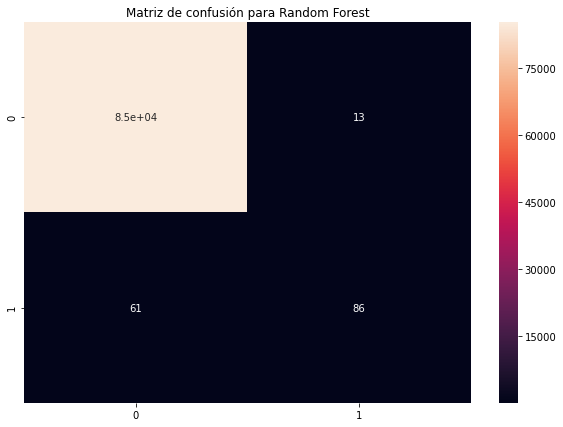

In [28]:
random_forest_confusion_matrix = confusion_matrix(y_test, random_forest_preds)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(random_forest_confusion_matrix, ax=ax, annot=True)
plt.title('Matriz de confusión para Random Forest')
plt.show()

El modelo tradó mucho en entrenar, sustancialmente más que la regresión logística. El resultado es sólo un poco mejor. 
- Para la detección de transacciones legítimas este modelo conserva la buena performance del modelo anterior.
- LA AUC aumentó, pero todavía no alcanza un AUC = .97 que haría al modelo excelente. 
- El recall mejoró un poco, pero sigue siendo pobre. Todavía es sensible a falsos negativos.

In [152]:
class_balances = y_train.value_counts()
class_balances[0] / class_balances[1]

576.8666666666667

La clase de transacciones no fraudulentas es 577 veces más frecuente que la clase de transacciones fraudulentas en el conjunto de train. 

---

# Improvement de los modelos

A partir de este punto, hay dos enfoques a tomar (y eventualmente a combinar)
- Resampling: usando ```SMOTE``` de ```imbalanced_learn``` puedo oversamplear la clase minoritaria para que el modelo que elija tenga más datos de entrenamiento.
- Class-weight: puedo pesar los datos de entrenamiento en donde se encuentre la clase desbalanceada en el mismo proceso de entrenamiento del modelo.

In [172]:
logit_oversample = LogisticRegression(class_weight='balanced')
logit_oversample.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [169]:
logit_oversample_preds = logit_oversample.predict(X_test)
print(classification_report(y_test, logit_oversample_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.77      0.28      0.41       147

    accuracy                           1.00     85443
   macro avg       0.89      0.64      0.70     85443
weighted avg       1.00      1.00      1.00     85443



In [170]:
confusion_matrix(y_test, logit_oversample_preds)

array([[85284,    12],
       [  106,    41]], dtype=int64)

---

# Oversampling

In [68]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

## Regresión logística con SMOTE

In [69]:
logit_res = LogisticRegression(random_state=0)
logit_res.fit(X_res, y_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
logit_res_preds = logit_res.predict(X_test)

In [75]:
logit_res_report = classification_report(y_test, logit_res_preds)
print(logit_res_report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.09      0.88      0.16       147

    accuracy                           0.98     85443
   macro avg       0.55      0.93      0.58     85443
weighted avg       1.00      0.98      0.99     85443



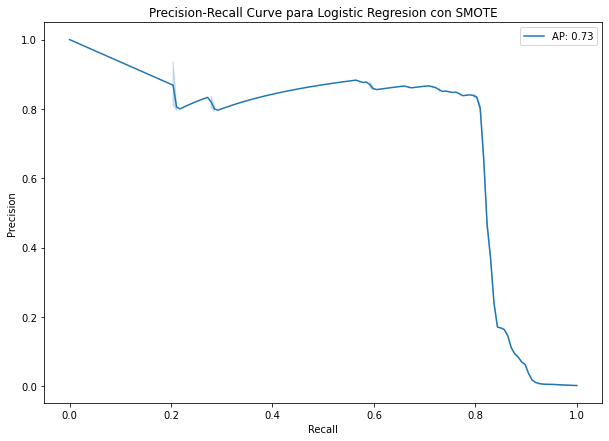

In [77]:
logit_res_preds_probas = logit_res.predict_proba(X_test)
logit_res_pos_preds_probas = logit_res_preds_probas[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, logit_res_pos_preds_probas)
average_precision = average_precision_score(y_test, logit_res_pos_preds_probas)

fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(recall, precision, ax=ax, label=f'AP: {round(average_precision,2)}')
plt.title('Precision-Recall Curve para Logistic Regresion con SMOTE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

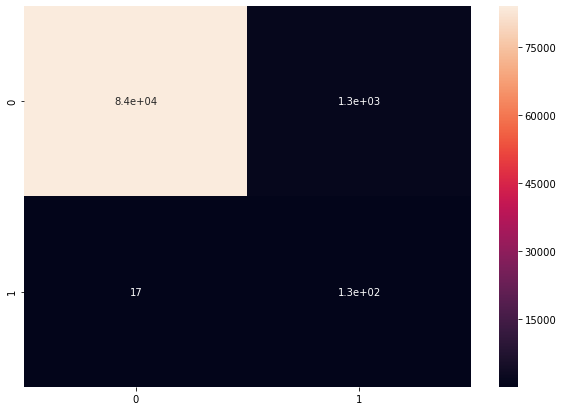

In [78]:
confusion_matrix_logit_res = confusion_matrix(y_test, logit_res_preds)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(confusion_matrix_logit_res, annot=True, ax=ax)
plt.show()

---

## Random Forest con SMOTE

In [83]:
random_forest_res = RandomForestClassifier(random_state=0)
random_forest_res.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [84]:
random_forest_res_preds = random_forest_res.predict(X_test)

In [89]:
len(random_forest_res_preds)

85443

In [85]:
random_forest_res_report = classification_report(y_test, random_forest_res_preds)
print(random_forest_res_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.81      0.85       147

    accuracy                           1.00     85443
   macro avg       0.95      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



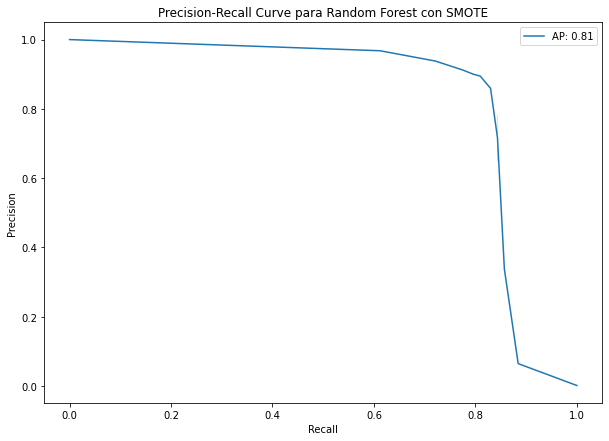

In [86]:
random_forest_res_preds_probas = random_forest_res.predict_proba(X_test)
random_forest_res_pos_preds_probas = random_forest_res_preds_probas[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, random_forest_res_pos_preds_probas)
average_precision = average_precision_score(y_test, random_forest_res_pos_preds_probas)

fig, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(recall, precision, ax=ax, label=f'AP: {round(average_precision,2)}')
plt.title('Precision-Recall Curve para Random Forest con SMOTE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [91]:
y_test.value_counts()

0    85296
1      147
Name: Class, dtype: int64

In [92]:
confusion_matrix_random_forest_res

array([[85282,    14],
       [   28,   119]], dtype=int64)

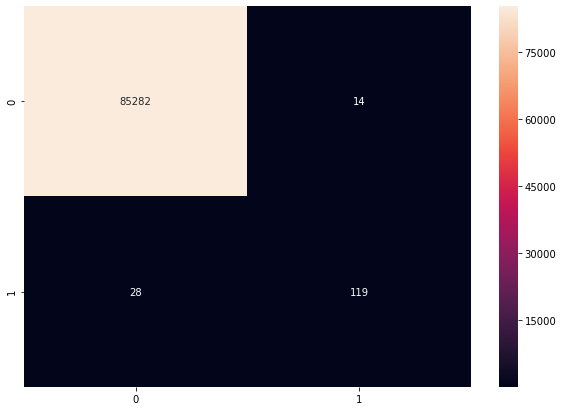

In [93]:
confusion_matrix_random_forest_res = confusion_matrix(y_test, random_forest_res_preds)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(confusion_matrix_random_forest_res, annot=True, ax=ax, fmt='g')
plt.show()